## Import libraries

In [1]:
from pycocotools.coco import COCO
import os, sys, zipfile
import shutil
import urllib.request
import requests
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Record package versions for reproducibility

In [2]:
print("os: {}".format(os.name))
print("sys: {}".format(sys.version))
print("numpy: {}, {}".format(np.__version__, np.__file__))

os: nt
sys: 3.8.1 (default, Jan  8 2020, 15:55:49) [MSC v.1916 64 bit (AMD64)]
numpy: 1.18.1, C:\Users\bluep\Anaconda3\envs\capstone\lib\site-packages\numpy\__init__.py


## Setup data paths

In [3]:
dataDir = '..'
dataType = 'val2017'
annDir = '{}/annotations'.format(dataDir)
annZipFile = '{}/annotations_train{}.zip'.format(dataDir, dataType)
annFile = '{}/instances_{}.json'.format(annDir, dataType)
annURL = 'http://images.cocodataset.org/annotations/annotations_train{}.zip'.format(dataType)
print(annDir)
print(annFile)
print(annZipFile)
print(annURL)

../annotations
../annotations/instances_val2017.json
../annotations_trainval2017.zip
http://images.cocodataset.org/annotations/annotations_trainval2017.zip


## Download data if not available locally

In [4]:
if not os.path.exists(annDir):
    os.makedirs(annDir)
if not os.path.exists(annFile):
    if not os.path.exists(annZipFile):
        print("Downloading zipped annotations to " + annZipFile + " ...")
        with urllib.request.urlopen(annURL) as resp, open(annZipFile, 'wb') as out:
            shutil.copyfileobj(resp, out)
        print("... done downloading")
    print("Unzipping " + annZipFile)
    with zipfile.ZipFile(annZipFile, "r") as zip_ref:
        zip_ref.extractall(dataDir)
    print("... done unzipping")
print("will use annotations in " + annFile)

will use annotations in ../annotations/instances_val2017.json


## Initialize COCO API for instance annotations

In [32]:
coco = COCO(annFile)

loading annotations into memory...
Done (t=0.70s)
creating index...
index created!


In [6]:
imgIds = coco.getImgIds()
print(len(imgIds))
annIds = coco.getAnnIds(imgIds=imgIds)
print(len(annIds))
print(annIds[0:10])
anns = coco.loadAnns(annIds)
print(len(anns))
print(anns[0])

5000
36781
[82445, 119568, 200887, 693231, 713388, 716434, 1125079, 1218137, 1878837, 1883614]
36781
{'segmentation': [[224.24, 297.18, 228.29, 297.18, 234.91, 298.29, 243.0, 297.55, 249.25, 296.45, 252.19, 294.98, 256.61, 292.4, 254.4, 264.08, 251.83, 262.61, 241.53, 260.04, 235.27, 259.67, 230.49, 259.67, 233.44, 255.25, 237.48, 250.47, 237.85, 243.85, 237.11, 240.54, 234.17, 242.01, 228.65, 249.37, 224.24, 255.62, 220.93, 262.61, 218.36, 267.39, 217.62, 268.5, 218.72, 295.71, 225.34, 297.55]], 'area': 1481.3806499999994, 'iscrowd': 0, 'image_id': 397133, 'bbox': [217.62, 240.54, 38.99, 57.75], 'category_id': 44, 'id': 82445}


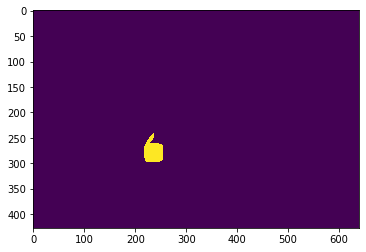

In [8]:
mask = coco.annToMask(anns[0])
plt.imshow(mask)

In [60]:
def cocoSegmentationToSegmentationMap(coco, imgId, checkUniquePixelLabel=True, includeCrowd=False):
    '''
    Convert COCO GT or results for a single image to a segmentation map.
    :param coco: an instance of the COCO API (ground-truth or result)
    :param imgId: the id of the COCO image
    :param checkUniquePixelLabel: (optional) whether every pixel can have at most one label
    :param includeCrowd: whether to include 'crowd' thing annotations as 'other' (or void)
    :return: labelMap - [h x w] segmentation map that indicates the label of each pixel
    '''

    # Init
    curImg = coco.imgs[imgId]
    imageSize = (curImg['height'], curImg['width'])
    labelMap = np.zeros(imageSize)

    # Get annotations of the current image (may be empty)
    imgAnnots = [a for a in coco.anns.values() if a['image_id'] == imgId]
    if includeCrowd:
        annIds = coco.getAnnIds(imgIds=imgId)
    else:
        annIds = coco.getAnnIds(imgIds=imgId, iscrowd=False)
    imgAnnots = coco.loadAnns(annIds)

    # Combine all annotations of this image in labelMap
    #labelMasks = mask.decode([a['segmentation'] for a in imgAnnots])
    for a in range(0, len(imgAnnots)):
        labelMask = coco.annToMask(imgAnnots[a]) == 1
        #labelMask = labelMasks[:, :, a] == 1
        newLabel = imgAnnots[a]['category_id']

        if checkUniquePixelLabel and (labelMap[labelMask] != 0).any():
            raise Exception('Error: Some pixels have more than one label (image %d)!' % (imgId))

        labelMap[labelMask] = newLabel

    return labelMap

(640, 480)
18.0
[ 0.  1. 15. 18. 41. 84.]


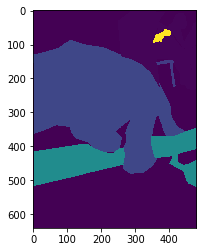

In [73]:
labelMap = cocoSegmentationToSegmentationMap(coco, 549220, checkUniquePixelLabel=False)
print(labelMap.shape)
plt.imshow(labelMap)
print(labelMap[200][100])
print(np.unique(labelMap))

In [72]:
ex = np.array([[0, 0, 1], [1, 2, 3], [0, 2, 1]])
R = ex.shape[0]
C = ex.shape[1]
ex1 = np.zeros((R, C, 4))
for r in range(R):
    for c in range(C):
        i = ex[r][c]
        ex1[r][c][i] = 1
print(ex)
print(ex1)

[[0 0 1]
 [1 2 3]
 [0 2 1]]
[[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]]

 [[1. 0. 0. 0.]
  [0. 0. 1. 0.]
  [0. 1. 0. 0.]]]


## Display COCO categories and supercategories

In [31]:
cats = coco.loadCats(coco.getCatIds())
nms = [cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))
nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
electronic kitchen sports person accessory furniture appliance animal outdoor food indoor vehicle


##  Get all images containing given categories, for an example

In [57]:
catIds = coco.getCatIds(catNms=['person', 'dog', 'skateboard'])
imgIds = coco.getImgIds(catIds=catIds)
imgs = coco.loadImgs(imgIds)
annIds = coco.getAnnIds(imgIds=imgIds)
anns = coco.loadAnns(annIds)
mask = coco.annToMask(anns[4])

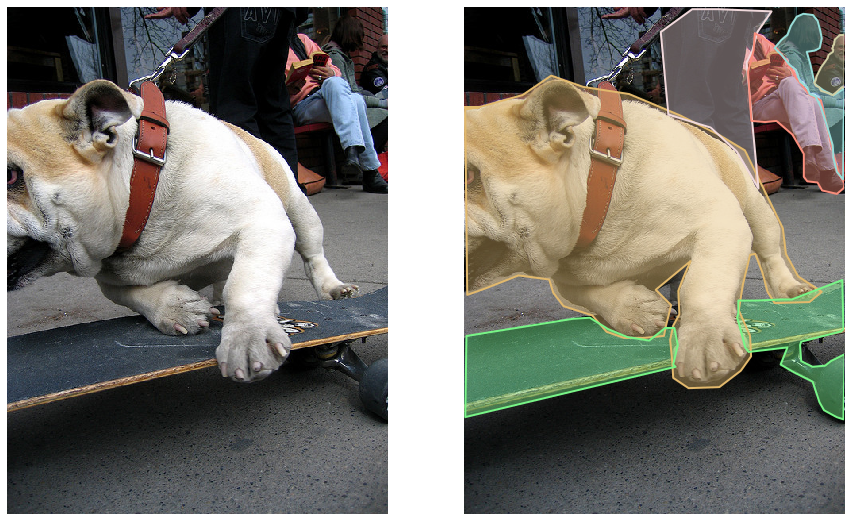

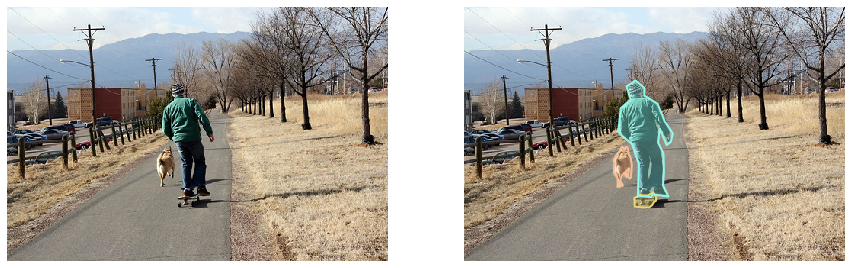

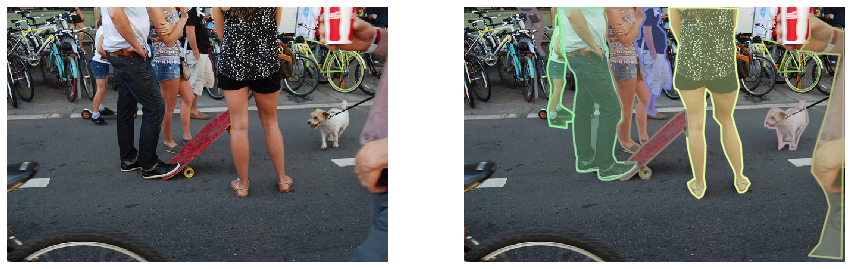

In [58]:
for img in imgs:
    I = io.imread(img['coco_url'])
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 15))
    ax1.axis('off')
    ax1.imshow(I) 
    ax2.axis('off')
    ax2.imshow(I)    
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    coco.showAnns(anns)
plt.show()

## Download 2017 validation images for simplicity
A size of training images is too large for data exploration

In [ ]:
# catIds = coco.getCatIds()
imgIds = coco.getImgIds()
imgs = coco.loadImgs(imgIds)
imgType = 'val2017'
imgDir = '../downloaded_images_{}/'.format(imgType)
if not os.path.exists(imgDir):
    os.makedirs(imgDir)
    for im in imgs:
        img_data = requests.get(im['coco_url']).content
        with open(imgDir + im['file_name'], 'wb') as handler:
            handler.write(img_data)

## Create COCO dataset for pytorch

In [ ]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image

In [ ]:
class myCOCODataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))
        
    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))
        
        # number of objects in the image
        num_objs = len(coco_annotation)
        
        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xman, ymax])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num.objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotations[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Is crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        # Annoation is in dictionary format
        my_annotation = {}
        my_annotation['boxes'] = boxes
        my_annotation['labels'] = labels
        my_annotation['image_id'] = img_id
        my_annotation['area'] = areas
        my_annotation['iscrowd'] = iscrowd
        
        if self.transforms is not None:
            img = self.transfomrs(img)
            
        return img, my_annotation
    
    def __len__(self):
        return len(self.ids)

In [ ]:
# In my case, just added ToTensor
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

In [ ]:
# path to my own data and annotation file
